In [1]:
%reload_ext autoreload
%autoreload 2

import os
import logging
import multiprocessing

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
import scipy.stats as stats

import numpyro
import numpyro.distributions as dist

from hbmep.model import Baseline
from hbmep_paper.utils.constants import HBM
from hbmep.config import Config
from hbmep.model.utils import Site as site

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()

logger = logging.getLogger(__name__)


In [2]:
class HierarchicalBayesianModel(Baseline):
    LINK = HBM

    def __init__(self, config: Config):
        super(HierarchicalBayesianModel, self).__init__(config=config)
        self.combination_columns = self.features + [self.subject]
        self.priors = {"baseline", "delta", site.a, site.b, site.L, site.H, site.v, site.g_1, site.g_2}

    def _model(self, subject, features, intensity, response_obs=None):
        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)

        n_data = intensity.shape[0]
        n_subject = np.unique(subject).shape[0]
        n_feature0 = np.unique(feature0).shape[0]

        n_baseline = 1
        n_delta = n_feature0 - 1

        """ Baseline """
        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_baseline", n_baseline, dim=-2):
                mu_baseline = numpyro.sample(
                    "mu_baseline",
                    dist.TruncatedNormal(5, 10, low=0)
                )
                sigma_baseline = numpyro.sample(
                    "sigma_baseline",
                    dist.HalfNormal(10.0)
                )

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    baseline = numpyro.sample(
                        "baseline",
                        dist.TruncatedNormal(mu_baseline, sigma_baseline, low=0)
                    )

        """ Delta """
        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_delta", n_delta, dim=-2):
                mu_delta = numpyro.sample("mu_delta", dist.Normal(0, 10))
                sigma_delta = numpyro.sample("sigma_delta", dist.HalfNormal(10.0))

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    delta = numpyro.sample("delta", dist.Normal(mu_delta, sigma_delta))

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_feature0", n_feature0, dim=-2):
                """ Hyper-priors """
                sigma_b = numpyro.sample(site.sigma_b, dist.HalfNormal(10))

                sigma_L = numpyro.sample(site.sigma_L, dist.HalfNormal(2))
                sigma_H = numpyro.sample(site.sigma_H, dist.HalfNormal(10))
                sigma_v = numpyro.sample(site.sigma_v, dist.HalfNormal(10))

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    """ Priors """
                    a = numpyro.deterministic(
                        site.a,
                        jnp.concatenate([baseline, baseline + delta], axis=1)
                    )
                    b = numpyro.sample(site.b, dist.HalfNormal(sigma_b))

                    L = numpyro.sample(site.L, dist.HalfNormal(sigma_L))
                    H = numpyro.sample(site.H, dist.HalfNormal(sigma_H))
                    v = numpyro.sample(site.v, dist.HalfNormal(sigma_v))

                    g_1 = numpyro.sample(site.g_1, dist.Exponential(0.01))
                    g_2 = numpyro.sample(site.g_2, dist.Exponential(0.01))

        """ Model """
        mu = numpyro.deterministic(
            site.mu,
            L[subject, feature0]
            + jnp.maximum(
                0,
                -1
                + (H[subject, feature0] + 1)
                / jnp.power(
                    1
                    + (jnp.power(1 + H[subject, feature0], v[subject, feature0]) - 1)
                    * jnp.exp(-b[subject, feature0] * (intensity - a[subject, feature0])),
                    1 / v[subject, feature0]
                )
            )
        )
        beta = numpyro.deterministic(
            site.beta,
            g_1[subject, feature0] + g_2[subject, feature0] * (1 / mu) ** 2
        )

        """ Penalty """
        penalty = (jnp.fabs(baseline + delta) - (baseline + delta))
        numpyro.factor("penalty", -penalty)

        """ Observation """
        with numpyro.plate(site.data, n_data):
            return numpyro.sample(
                site.obs,
                dist.Gamma(concentration=mu * beta, rate=beta).to_event(1),
                obs=response_obs
            )

In [3]:
prefix = "power-analysis-parallel"

toml_path = "/home/vishu/repos/hbmep-paper/configs/human/intraoperative/config.toml"
CONFIG = Config(toml_path=toml_path)
MODEL = HierarchicalBayesianModel(config=CONFIG)

keys = jax.random.split(MODEL.rng_key, num=2)

N_space = [2, 4, 8, 12, 16, 20]

n_draws = 50
draws_space = \
    jax.random.choice(
        key=keys[0],
        a=np.arange(0, 4000, 1),
        shape=(n_draws,),
        replace=False
    ) \
    .tolist()

n_repeats = 50
repeats_space = \
    jax.random.choice(
        key=keys[1],
        a=np.arange(0, n_repeats * 100, 1),
        shape=(n_repeats,),
        replace=False
    ) \
    .tolist()

2023-10-02 14:13:36,373 - hbmep.config - INFO - Verifying configuration ...
2023-10-02 14:13:36,392 - hbmep.config - INFO - Success!


2023-10-02 14:13:36,650 - hbmep.model.baseline - INFO - Initialized model with hierarchical_bayesian link


In [4]:
mu_delta = None

for N in N_space:
    curr_N_mu_delta = None
    N_dir = f"N_{N}"

    for draw_ind in draws_space[:34]:
        curr_draw_mu_delta = None
        draw_dir = f"draw_{draw_ind}"

        for seed in repeats_space:
            seed_dir = f"seed_{seed}"

            src = os.path.join(MODEL.build_dir, prefix, draw_dir, N_dir, seed_dir, "mu_delta.npy")
            mu_delta_temp = np.load(src)

            mu_delta_temp = mu_delta_temp[None, ...]

            if curr_draw_mu_delta is None:
                curr_draw_mu_delta = mu_delta_temp
            else:
                curr_draw_mu_delta = np.concatenate([curr_draw_mu_delta, mu_delta_temp], axis=0)

        curr_draw_mu_delta = curr_draw_mu_delta[None, ...]

        if curr_N_mu_delta is None:
            curr_N_mu_delta = curr_draw_mu_delta
        else:
            curr_N_mu_delta = np.concatenate([curr_N_mu_delta, curr_draw_mu_delta], axis=0)

    curr_N_mu_delta = curr_N_mu_delta[None, ...]

    if mu_delta is None:
        mu_delta = curr_N_mu_delta
    else:
        mu_delta = np.concatenate([mu_delta, curr_N_mu_delta], axis=0)


In [5]:
mu_delta.shape

(6, 34, 50, 4000, 1, 1)

In [6]:
def _process(arr, rope):
    arr = ((mu_delta > rope).mean(axis=(-1, -2, 3)) > .95).mean(axis=-1)
    me = arr.mean(axis=-1)
    sem = stats.sem(arr, axis=-1)
    std = arr.std(axis=-1)
    return me, sem, std


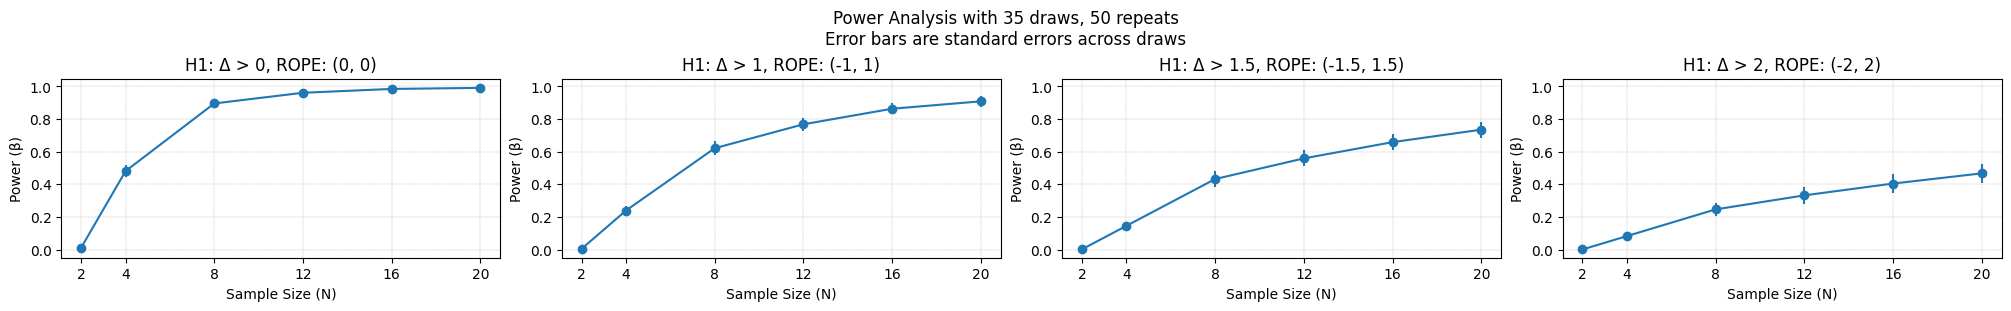

In [7]:
rope_space = [0, 1, 1.5, 2]

nrows, ncols = 1, len(rope_space)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows), squeeze=False, constrained_layout=True, sharex=True, sharey=True)

i = 0
for rope in rope_space:
    ax = axes[i // ncols, i % ncols]

    me, sem, std = _process(mu_delta, rope)

    ax.errorbar(x=N_space, y=me, yerr=sem, marker="o")

    ax.grid(linewidth=.3, linestyle="--", axis="both")
    ax.set_yticks(np.arange(0, 1.2, .2))
    ax.set_xticks(N_space)

    ax.set_title(f"H1: Δ > {rope}, ROPE: ({-1 * rope}, {rope})")
    ax.set_xlabel("Sample Size (N)")
    ax.set_ylabel("Power (β)")

    ax.yaxis.set_tick_params(labelleft=True)

    i += 1

fig.suptitle(f"Power Analysis with {35} draws, {n_repeats} repeats\nError bars are standard errors across draws");

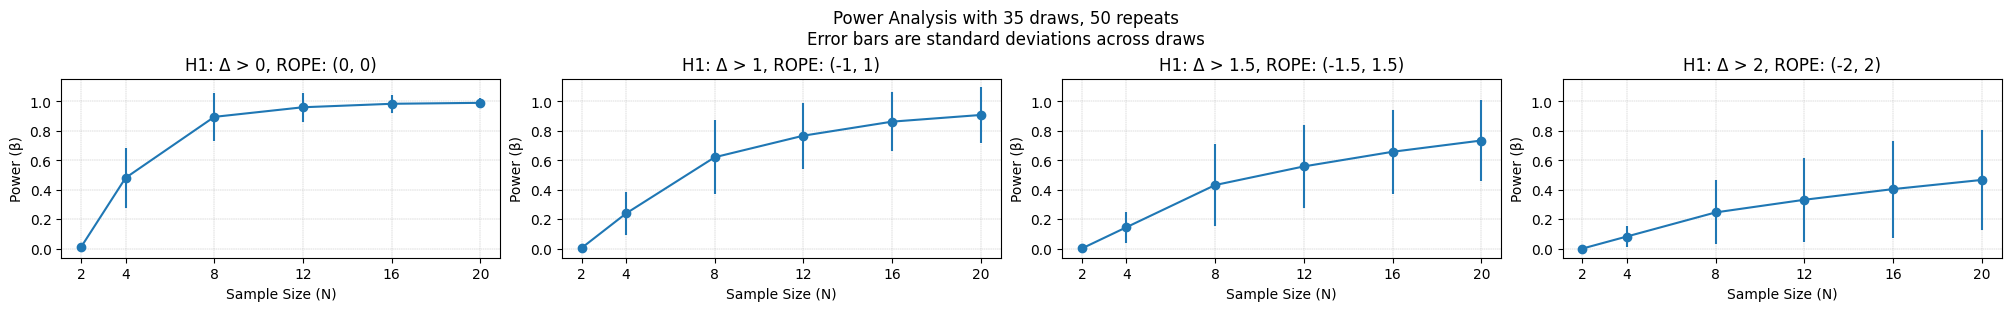

In [8]:
rope_space = [0, 1, 1.5, 2]

nrows, ncols = 1, len(rope_space)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows), squeeze=False, constrained_layout=True, sharex=True, sharey=True)

i = 0
for rope in rope_space:
    ax = axes[i // ncols, i % ncols]

    me, sem, std = _process(mu_delta, rope)

    ax.errorbar(x=N_space, y=me, yerr=std, marker="o")

    ax.grid(linewidth=.3, linestyle="--", axis="both")
    ax.set_yticks(np.arange(0, 1.2, .2))
    ax.set_xticks(N_space)

    ax.set_title(f"H1: Δ > {rope}, ROPE: ({-1 * rope}, {rope})")
    ax.set_xlabel("Sample Size (N)")
    ax.set_ylabel("Power (β)")

    ax.yaxis.set_tick_params(labelleft=True)

    i += 1

fig.suptitle(f"Power Analysis with {35} draws, {n_repeats} repeats\nError bars are standard deviations across draws");

In [18]:
rope = 0

arr = ((mu_delta > rope).mean(axis=(-1, -2, 3)) > .95).mean(axis=-1)
arr.shape

(6, 34)

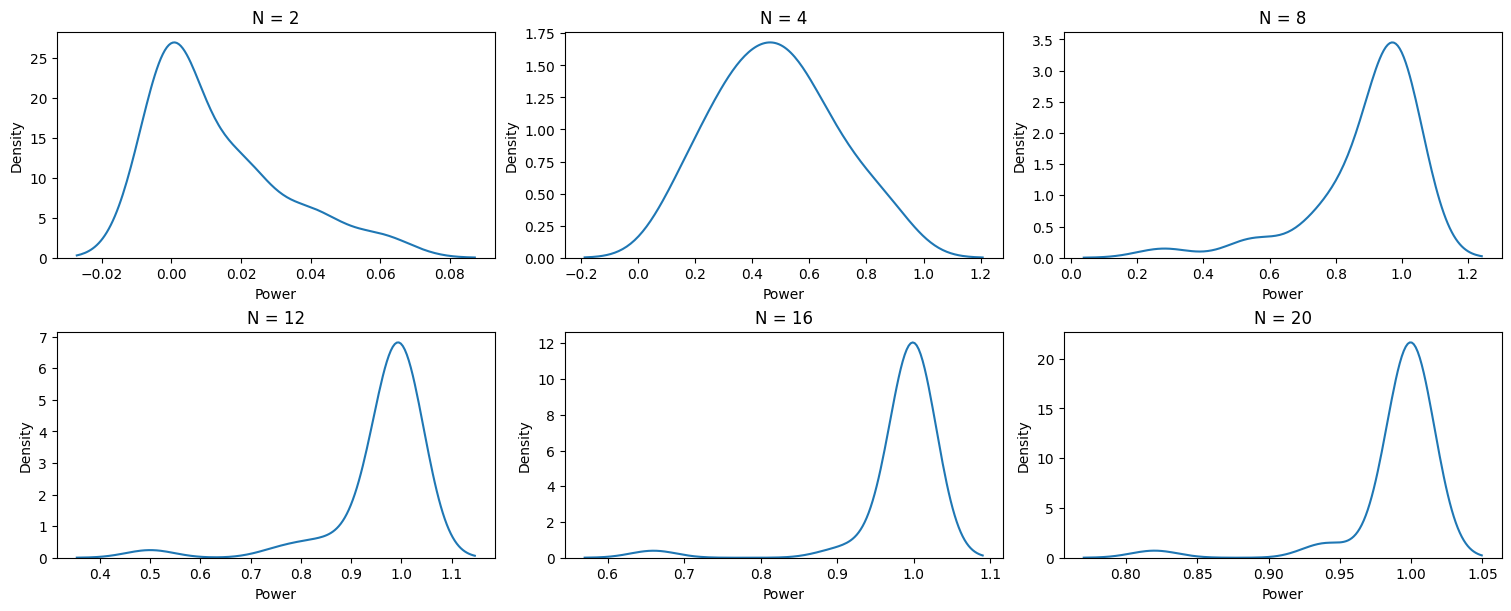

In [19]:
nrows, ncols = 2, 3

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows), squeeze=False, constrained_layout=True)

i = 0
for _ in range(arr.shape[0]):
    ax = axes[i // ncols, i % ncols]
    sns.kdeplot(arr[i, ...], ax=ax)
    ax.set_title(f"N = {N_space[i]}")
    ax.set_xlabel("Power")
    i += 1
